# Libraries

In [ ]:
# if you use google colab, install the following libraries:
# !pip install emoji datasets contractions pyLDAvis fasttext -U ipykernel

In [50]:
import os
import pickle
from pprint import pprint

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import gensim
import gensim.corpora as corpora
from gensim.utils import tokenize
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import pyLDAvis

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

plt.style.use('seaborn-v0_8-pastel')

# Introduction

We're going to use Latent Dirichlet allocation (LDA) to find latent topics in the amazon review data set previously pre-processed. For that, we're going to use the Gensim library to apply LDA and evaluate the best model we could find.

# Load data set

In [2]:
# load pre-processed data

df = pd.read_parquet('../data/processed/df_amazon_reviews_sample_5k_review_body_preprocessed.gzip')

# Topic modeling

## Prepare LDA

In [3]:
# check data set

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1660627 to 991948
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   marketplace                    5000 non-null   object
 1   customer_id                    5000 non-null   object
 2   review_id                      5000 non-null   object
 3   product_id                     5000 non-null   object
 4   product_parent                 5000 non-null   object
 5   product_title                  5000 non-null   object
 6   product_category               5000 non-null   object
 7   star_rating                    5000 non-null   int32 
 8   helpful_votes                  5000 non-null   int32 
 9   total_votes                    5000 non-null   int32 
 10  vine                           5000 non-null   int64 
 11  verified_purchase              5000 non-null   int64 
 12  review_headline                5000 non-null   object
 13  

In [22]:
# tokenize reviews
def tokenize_reviews(sentences):
    tokens = []
    for sentence in sentences:
        tokens.append(list(tokenize(sentence)))
    return tokens

data = df.review_body_preprocessed.values.tolist()
data_tokens = list(tokenize_reviews(data))

In [32]:
# visualize tokens
for i, doc_tokenized in enumerate(data_tokens[:5]):
    print(f"{i}: {'-'.join(doc_tokenized)}")

0: really-checked-earlier-later-due-system-requirement-high-version-ea-sport-nhl-game-pc-quite-nicely-long-time-even-get-faster-better-computer-someday-pentium-iii-mhz-g-hard-drive-ram-mb-video-card-pretty-low-spec-day-good-enough-run-perfectly-hockey-game-really-need-price-even-find-hard-imagine-get-much-realistic-hockey-game-pc-pricebr-graphic-game-excellent-rival-anything-ever-seen-pc-console-cinematic-scene-like-beginning-game-team-take-ice-almost-look-like-real-tv-game-used-game-shabby-either-sharpened-ice-skate-previous-incarnation-nhl-game-old-nintendo-super-nintendo-genesis-even-psone-graphic-blow-rest-ice-long-shotbr-opening-little-movie-scene-joy-watch-great-music-visuals-even-playing-game-many-time-still-love-watch-really-pump-nhl-hockeybr-sound-effect-crowd-noise-reaction-announcer-great-customization-galore-play-nhl-team-various-international-one-well-even-create-team-customize-jersey-even-paste-picture-face-player-make-game-hard-easy-everything-numerous-camera-angle-try-g

In [38]:
# build a bigram model
bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100) # higher threshold fewer phrases.

# optimize model to get a sentence grouped as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# see example
print(df.head(1).review_body.tolist())
print(bigram_mod[data_tokens[0]])

['I really haven\'t checked out earlier or later (due to system requirements being too high) versions of EA Sport\'s NHL games for the PC, but this will do quite nicely for a long time, even if I do get that faster, better computer someday.  As it is, on my Pentium III 600mhz, with 10g hard drive, 256ram, and 4mb 3d video card (pretty low specs these days, but good enough for now), this runs perfectly, and is the ONLY hockey game you really need for the price.  I even find it hard to imagine you CAN get a much more realistic hockey game on the PC, at any price.<br />The graphics in this game are excellent.  They rival anything I\'ve ever seen on any PC or console.  Some of the cinematic scenes, like at the beginning of a game when both teams take the ice, almost look like a real TV game.  Those used during the game itself aren\'t too shabby either.  As one who sharpened his ice skates on previous incarnations of NHL games such as those on the old Nintendo, Super Nintendo, Genesis, and 

Here we can see that the bigram model has detected some composed terms like ea_sport and hard_drive

In [39]:
# make bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

data_words_bigrams = make_bigrams(data_tokens)

In [46]:
# look bigrams found
bigrams = []
for doc in data_words_bigrams:
    for term in doc:
        if '_' in term:
            bigrams.append(term)
print(np.unique(bigrams[:50]))

['back_forth' 'baldurs_gate' 'call_duty' 'camera_angle' 'customer_service'
 'cut_scene' 'dark_soul' 'dragon_quest' 'dragon_warrior' 'ea_sport'
 'every_penny' 'exactly_described' 'expansion_pack' 'final_fantasy'
 'frame_rate' 'gameboy_advance' 'gear_war' 'god_war' 'hack_slash'
 'hard_drive' 'highly_recommend' 'highly_recommended' 'let_u' 'lord_ring'
 'nintendo_d' 'pain_butt' 'person_shooter' 'replay_value' 'resident_evil'
 'single_player' 'split_screen' 'square_enix' 'survival_horror'
 'voice_acting' 'wii_remote' 'worked_perfectly' 'year_ago' 'year_old']


In [47]:
# dictionary - vocabulary
id2word = corpora.Dictionary(data_words_bigrams)

# corpus
texts = data_words_bigrams

# term document frequency (bow)
lda_corpus = [id2word.doc2bow(text) for text in texts]

# view
print(lda_corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 3), (7, 2), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 6), (16, 1), (17, 2), (18, 1), (19, 2), (20, 2), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 2)]


The interpretation of this is the following. For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

## Build LDA

In [54]:
# number of topics
num_topics = 10

# build LDA model
lda_model = gensim.models.LdaMulticore(corpus=lda_corpus,
                                    id2word=id2word,
                                    num_topics=num_topics,
                                    alpha='symmetric',
                                    eta=0.1)

# print the key words in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[lda_corpus]

[(0,
  '0.033*"game" + 0.013*"like" + 0.012*"get" + 0.009*"play" + 0.006*"great" + '
  '0.006*"time" + 0.006*"really" + 0.005*"would" + 0.005*"work" + '
  '0.004*"much"'),
 (1,
  '0.025*"game" + 0.012*"good" + 0.008*"would" + 0.007*"like" + 0.006*"well" + '
  '0.006*"also" + 0.006*"time" + 0.005*"play" + 0.005*"fun" + 0.005*"thing"'),
 (2,
  '0.031*"game" + 0.010*"get" + 0.009*"like" + 0.008*"time" + 0.006*"play" + '
  '0.006*"would" + 0.006*"great" + 0.005*"good" + 0.004*"really" + '
  '0.004*"thing"'),
 (3,
  '0.014*"game" + 0.013*"like" + 0.009*"good" + 0.008*"get" + 0.008*"really" + '
  '0.007*"great" + 0.006*"well" + 0.006*"work" + 0.005*"play" + 0.005*"would"'),
 (4,
  '0.058*"game" + 0.011*"play" + 0.009*"great" + 0.008*"like" + 0.007*"get" + '
  '0.006*"much" + 0.006*"fun" + 0.006*"time" + 0.006*"love" + 0.005*"even"'),
 (5,
  '0.027*"game" + 0.008*"time" + 0.007*"great" + 0.007*"get" + 0.006*"like" + '
  '0.006*"would" + 0.005*"way" + 0.005*"really" + 0.005*"play" + 0.004*"mak

In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
ldavis_data_filepath = os.path.join(f'../reports/topic_modeling/ldavis_prepared_{num_topics}.bin')

# save lda visualization data and load it if it exists

if os.path.isfile(ldavis_data_filepath):
    # load the pre-prepared pyLDAvis data from disk
    with open(ldavis_data_filepath, 'rb') as f:
        ldavis_prepared = pickle.load(f)
    print('Lda visualization data loaded')
else:
    # prepare lda visualization
    ldavis_prepared = pyLDAvis.gensim.prepare(lda_model, lda_corpus, id2word)

    # save the pre-prepared pyLDAvis data
    with open(ldavis_data_filepath, 'wb') as f:
        pickle.dump(ldavis_prepared, f)
    print('Lda visualization data saved')

Lda visualization data loaded


In [69]:
pyLDAvis.save_html(ldavis_prepared, ldavis_data_filepath.split('.bin')[0]+'.html')
ldavis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.027321 -0.003767       1        1  36.746844
2      0.003211 -0.004882       2        1  10.329898
8      0.015670 -0.005042       3        1   9.656853
5     -0.001288  0.006041       4        1   9.347716
9      0.018866 -0.006392       5        1   9.196025
0      0.002189 -0.006339       6        1   8.877049
6     -0.003050  0.016482       7        1   4.847460
1     -0.013034  0.008683       8        1   4.770593
3     -0.034022 -0.023539       9        1   4.050588
7     -0.015863  0.018755      10        1   2.176973, topic_info=       Term          Freq         Total Category  logprob  loglift
64     game  10101.000000  10101.000000  Default  30.0000  30.0000
71     good   1282.000000   1282.000000  Default  29.0000  29.0000
90     like   2047.000000   2047.000000  Default  28.0000  28.0000
67      get   1735.000000   1735.000000  Default  27.0000  27.0000
206   would   1283.000000   1283.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
212   first     15.350711    905.466714  Topic10  -5.8248  -0.2501
101    make     14.769295    876.411402  Topic10  -5.8635  -0.2561
2      also     14.638062    897.475835  Topic10  -5.8724  -0.2887
148  really     15.317997   1175.091549  Topic10  -5.8270  -0.5128
514       p     13.119609    606.065968  Topic10  -5.9819  -0.0056

[879 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
18592      8  0.685860  aamazing
355        1  0.565697    action
355        2  0.062855    action
355        3  0.083807    action
355        4  0.062855    action
...      ...       ...       ...
11282      6  0.298279        yo
6409       2  0.176366    zipper
6409       4  0.176366    zipper
6409       8  0.352733    zipper
6409       9  0.352733    zipper

[2287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 9, 6, 10, 1, 7, 2, 4, 8])

## Evaluation

In [71]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -1.4817784528893911


In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word,
                                           alpha='symmetric',
                                           eta=0.1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [75]:
# Can take a long time to run.
start = 2
limit = 40
step = 6
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=lda_corpus, texts=data_words_bigrams, start=start, limit=limit, step=step)

  0%|          | 0/7 [00:00<?, ?it/s]

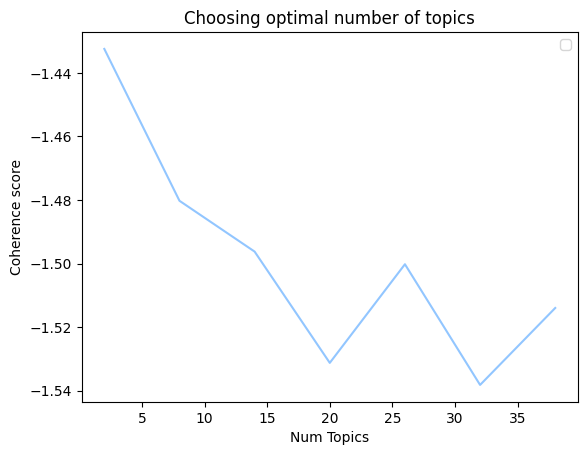

In [84]:
# plot coherence graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title('Choosing optimal number of topics')
plt.legend();

In [85]:
for n_topics, coherence_scores in zip(x, coherence_values):
    print("Num Topics =", n_topics, " has Coherence Value of", round(coherence_scores, 4))

Num Topics = 2  has Coherence Value of -1.4325
Num Topics = 8  has Coherence Value of -1.4802
Num Topics = 14  has Coherence Value of -1.4962
Num Topics = 20  has Coherence Value of -1.5312
Num Topics = 26  has Coherence Value of -1.5002
Num Topics = 32  has Coherence Value of -1.5382
Num Topics = 38  has Coherence Value of -1.514


## Interpretation

In [88]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.054*"game" + 0.009*"get" + 0.008*"like" + 0.007*"good" + 0.007*"play" + '
  '0.007*"time" + 0.007*"fun" + 0.006*"great" + 0.006*"would" + '
  '0.005*"really"'),
 (1,
  '0.024*"game" + 0.009*"get" + 0.009*"play" + 0.007*"great" + 0.006*"like" + '
  '0.005*"would" + 0.005*"graphic" + 0.005*"work" + 0.005*"time" + '
  '0.005*"back"'),
 (2,
  '0.034*"game" + 0.009*"get" + 0.008*"like" + 0.008*"time" + 0.007*"play" + '
  '0.007*"controller" + 0.006*"good" + 0.006*"would" + 0.006*"work" + '
  '0.006*"great"'),
 (3,
  '0.027*"game" + 0.008*"time" + 0.007*"like" + 0.006*"get" + 0.006*"good" + '
  '0.006*"play" + 0.005*"controller" + 0.004*"new" + 0.004*"love" + '
  '0.004*"character"'),
 (4,
  '0.037*"game" + 0.009*"great" + 0.008*"time" + 0.007*"good" + 0.006*"really" '
  '+ 0.006*"get" + 0.005*"like" + 0.005*"would" + 0.005*"still" + '
  '0.004*"well"'),
 (5,
  '0.042*"game" + 0.014*"like" + 0.010*"play" + 0.008*"would" + 0.005*"get" + '
  '0.005*"also" + 0.005*"even" + 0.005*"time

In [117]:
def format_topics_sentences(ldamodel, corpus, texts):
    # init output
    sent_topics = {'Dominant_Topic':[], 'Perc_Contribution':[], 'Topic_Keywords':[]}

    # get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # get the dominant topic, percentage of contribution and key words for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics['Dominant_Topic'].append(int(topic_num))
                sent_topics['Perc_Contribution'].append(round(prop_topic,4))
                sent_topics['Topic_Keywords'].append(topic_keywords)
            else:
                break
    sent_topics_df = pd.DataFrame(sent_topics)

    # add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [118]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=lda_corpus, texts=data_words_bigrams)

# format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6,0.5393,"game, like, great, play, really, get, fun, wou...","[really, checked, earlier, later, due, system,..."
1,1,5,0.6323,"game, like, play, would, get, also, even, time...","[game, alright, year_old, son, like, play, res..."
2,2,5,0.9734,"game, like, play, would, get, also, even, time...","[con, nonebr, prosbr, classesbr, awesome, pvpb..."
3,3,0,0.9854,"game, get, like, good, play, time, fun, great,...","[wanted, play, game, husband, introduced, smal..."
4,4,2,0.9791,"game, get, like, time, play, controller, good,...","[yes, even, better, original, xbox, controller..."
5,5,2,0.6013,"game, get, like, time, play, controller, good,...","[purchased, good, friend, mine, happens, love,..."
6,6,0,0.9837,"game, get, like, good, play, time, fun, great,...","[wanted, add, voice, activation, failure, issu..."
7,7,2,0.9742,"game, get, like, time, play, controller, good,...","[n, trident, controller, good, thing, playing,..."
8,8,6,0.9900,"game, like, great, play, really, get, fun, wou...","[new, controller, huge, improvement, controlle..."
9,9,3,0.4977,"game, time, like, get, good, play, controller,...","[picked, whim, since, enjoy, puzzle, brainteas..."
